TANZANIA'S WATER PUMPS FUNCTIONALITY AND MAINTENANCE PREDICTION

The goal of this project is to provide a tool for predictive maintenance of water pumps in Tanzania. Tipically, the data set at the core of this work has been used in classification problems. Here, a Random Forest classifier is built for features selection, then survival regression and other algorithms are compared with the goal of predicting the number of years left before a water pump needs maintenance. The data set used in this project is available from different resources. It has been posted on DrivenData and Kaggle:

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

https://www.kaggle.com/c/ds1-predictive-modeling-challenge/overview

It is also available for direct download:

https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv (features)

https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv (labels)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import itertools

from collections import defaultdict

from lifelines import KaplanMeierFitter, WeibullAFTFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time, median_survival_times, k_fold_cross_validation
from lifelines.utils.sklearn_adapter import sklearn_adapter

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
# Seaborn plots settings
bcol=sns.color_palette('colorblind').as_hex()
sns.set_palette("colorblind")
sns.set(style='whitegrid')

DOWNLOAD DATA

In [3]:
#dfXd=pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
#dfyd=pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

# previously downloaded from the above links
dfX=pd.read_csv('tanzania/features.csv')
dfy=pd.read_csv('tanzania/labels.csv')

In [4]:
dfX.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [5]:
dfy.head(3)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional


DATA WRANGLING

In [6]:
print('Number of observations: ', dfX.shape[0])
print('Number of attributes: ', dfX.shape[1])
print('Same Id:', dfX['id'].equals(dfy['id']))

Number of observations:  59400
Number of attributes:  40
Same Id: True


Each row is a water pump, identified by a number. This information is dropped.

In [7]:
dfall=pd.concat([dfX,dfy['status_group']],axis=1)
dfId=dfall[['id']]
dfall.drop(['id'],axis=1,inplace=True)

In [8]:
dfall['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

"Status_group" is the variable to predict in the classifier. One class has much less observations. When the model for predictive maintenance is built, the "non functional" and "functional needs repair" classes will be combined. In fact, the purpose is to be able to give useful information to organize maintenance before a water pumps breaks.

In [9]:
# check for duplicates
dupl=dfall[dfall.duplicated()]
dupl

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
7709,0.0,2013-02-16,Dwsp,0,DWE,0.00000,-2.000000e-08,Sango,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
8731,0.0,2012-10-25,Dwsp,0,DWE,0.00000,-2.000000e-08,Wazazi,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
11260,0.0,2012-11-04,Government Of Tanzania,0,RWE,0.00000,-2.000000e-08,School,0,Lake Victoria,...,soft,good,insufficient,insufficient,lake,river/lake,surface,communal standpipe multiple,communal standpipe,non functional
13823,0.0,2013-02-16,Pmo,0,DWE,0.00000,-2.000000e-08,Muungano,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair
17133,0.0,2012-10-26,Holland,0,HOLLAND,0.00000,-2.000000e-08,Jamii,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
22080,0.0,2013-02-16,Rwssp,0,DWE,0.00000,-2.000000e-08,Muungano,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
22140,0.0,2013-02-16,Rwssp,0,DWE,0.00000,-2.000000e-08,none,0,Lake Victoria,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
25300,0.0,2011-07-27,Hesawa,0,DWE,0.00000,-2.000000e-08,Bombani,0,Lake Victoria,...,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
25928,0.0,2011-07-19,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Mulangila,0,Lake Victoria,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional
28518,0.0,2011-07-18,Government Of Tanzania,0,Government,0.00000,-2.000000e-08,Hospital,0,Lake Victoria,...,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional


The check for duplicates shows that there are weird entries, which may be an indication of missing informations. It looks like the duplicated check is based on numerical varibles, and there are no actual duplicates.

Some functions are used to help with analyzing the data and clean it.

In [10]:
def col_type(dataFr,col):
    
    '''identify type of data of a column/series'''
    
    tclass=type(dataFr[col][0])
    dtype=tclass.__name__

    return dtype

def dataFr_info(dataFr):
    
    '''create dictionary of data types in a dataframe
    print information on percentage of missing values'''
    
    types_dict=defaultdict(list)
    flag=0
    
    for col in dataFr.columns:
        key=col_type(dataFr,col)
        types_dict[key].append(col)
        nulls=nulls_perc(dataFr,col)
        if nulls[1]==0: continue
        print('Percentage of missing values in {}:'.format(col),nulls[1])
        flag=1
        
    if flag==0: print('There are no missing values in the dataframe')    
    print('\n')    
    
    for k,v in types_dict.items(): print('Number of columns of {} type:'.format(k),len(v),'\n',v,'\n')   
        
    return types_dict 

def nulls_perc(dataFr,col):
    
    ''' percentage and total number of missing values in a column'''
    
    values=dataFr[col].values
    #if col_type(dataFr,col)=='str': total=np.sum([nulls_cat(dataFr[col])[i].sum() for i in range(4)])
    if col_type(dataFr,col)=='str': 
        total=np.sum([nulls_cat(dataFr[col])[i].sum() for i in range(len(nulls_cat(dataFr[col])))])
    else: total=nulls_num(dataFr[col]).sum()  
    perc=round(total/len(values)*100,1)
    return total,perc    


def nulls_cat(col):
    
    '''find variuos types of missing conditions in categories'''
    
    cond0=col.isnull()
    cond1=col.str.startswith('-')
    cond2=col.str.startswith('0')
    cond3=col.str.startswith('?')
    cond4=col.str.startswith('none')
    return [cond0,cond1,cond2,cond3,cond4]    

def nulls_num(col):
    
    '''find missing values in numerical attributes'''
    
    return col.isnull()

In [11]:
all_types=dataFr_info(dfall)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in wpt_name: 6.0
Percentage of missing values in subvillage: 0.6
Percentage of missing values in public_meeting: 5.6
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in scheme_name: 47.5
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 29 
 ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 6 
 ['gps_hei

There are 40 attributes of various type. Some may contain redundant information. Also, some values are missing in the categorical variables columns. One of them, "scheme_name", has almost 50% of data missing, so it will be dropped.
The different types of attribute are dealt with separately.

To start with, the recorded year is extracted from "date_recorded". This is the time when the observation was recorded, and it will be used together with the "construction_year" to determine the age of a pump. The age will be the timeline for the survival regression model developed later on.

In [12]:
# only the year of observation is kept and it shouldn't be of object type
dfall['recorded_year'] = pd.DatetimeIndex(dfall['date_recorded']).year
dfall.drop(['date_recorded'],axis=1,inplace=True)

Before doing any encoding of categories and analyzing correlations, columns that don't have useful information because their value is unique or they have too many missing data are dropped.

In [13]:
def drop_columns(dataFr,perc=40):
    
    '''drop columns of a dataframe if they have more then a certain 
    percentage of missing values
    or if the value is unique'''
    
    print('Number of columns before drop:',len(dataFr.columns.values))
    dropped_cols=[]
    newDf=pd.DataFrame()
    for col in dataFr.columns.values:
        cond1=nulls_perc(dataFr,col)[1]>perc
        cond2=len(dataFr[col].unique())==1
        
        if cond1 or cond2:
            dropped_cols.append(col)

    newDf=dataFr.drop(dropped_cols,axis=1)
    print('Number of dropped columns:',len(dropped_cols))
    if len(dropped_cols)!=0: print('Dropped columns:',dropped_cols)
    return(newDf)    

In [14]:
df=drop_columns(dfall)

Number of columns before drop: 40
Number of dropped columns: 2
Dropped columns: ['recorded_by', 'scheme_name']


In [15]:
# check changes
new_types=dataFr_info(df)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in wpt_name: 6.0
Percentage of missing values in subvillage: 0.6
Percentage of missing values in public_meeting: 5.6
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 26 
 ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 7 
 ['gps_height', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'recorded

Boolean variables 

In [16]:
boolean=pd.concat([df[new_types['bool']],df['status_group']],axis=1)
boolean.groupby('status_group')[new_types['bool']].count()

,public_meeting,permit
status_group,,
functional,30581,30586
functional needs repair,4161,4017
non functional,21324,21741


In [17]:
def encode_bool(series):
    
    '''encode series of boolean to float,
    fill missing values'''
    
    series.replace({True:1, False:0},inplace=True)
    series.fillna(2,inplace=True)

    return series

In [18]:
df_bool=df[['public_meeting', 'permit']].copy()
df_bool_enc=encode_bool(df_bool)

Categorical variables

By the name of the attributes and their description available on some of the links, it's possible that they represent the same type of information. To confirm that, correlation between categorical variables is looked into. Before that, those that have missing values are filled in as "unknown". Also, for the purpose of encoding, if the number of levels is higher then a certain threshold, only the top 10 values in terms of frequency are kept, while the others are all grouped under "other". 

In [19]:
def count_cat(dataFr,cols):
    
    '''print number of levels for each categorical variable'''
    
    for col in cols: print(col,len(dataFr[col].unique()))

In [20]:
count_cat(dfall,new_types['str'])

funder 1898
installer 2146
wpt_name 37400
basin 9
subvillage 19288
region 21
lga 125
ward 2092
scheme_management 13
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
management_group 5
payment 7
payment_type 7
water_quality 8
quality_group 6
quantity 5
quantity_group 5
source 10
source_type 7
source_class 3
waterpoint_type 7
waterpoint_type_group 6
status_group 3


A couple of attributes, "subvillage" and "wpt_name" have a very high number of possible values. The former contains geographical information, which can also be derived from other attributes. The latter is the name of the water point, according to the documentation available. Instead of encoding these attributes, even after grouping them, they are dropped.

In [21]:
# this condition can also be added to the drop_columns function; a threshold can be used for the max number of values
# of a categorical attribute
df.drop(['subvillage','wpt_name'],axis=1,inplace=True)

In [22]:
#len(dfall.columns.values)
new_types=dataFr_info(df)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in public_meeting: 5.6
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 24 
 ['funder', 'installer', 'basin', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 7 
 ['gps_height', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'recorded_year'] 

Number of columns of bool type: 2 
 ['public_meeting', 'permit'] 



In [23]:
def fill_missing(col):
    
    '''fill missing values of a categorical variable'''
    
    #first replace nan
    col.fillna('unknown',inplace=True)
    cond_list=nulls_cat(col)
    for cond in cond_list[1:]: col[cond]='unknown'

In [24]:
def reduce_cat(series,num=10):
    
    '''replace entry that is not in the top num with the word "other" '''
    
    if len(series.unique())>num: top=num
    else: top=len(series.unique())    
       
    common=series.value_counts()[:top].index.tolist()
    print(common)
    series=series.apply(lambda val: 'Other' if val not in common else val)
    
    return series

In [25]:
df_str=df[new_types['str']].copy()
for col in df_str.columns: 
    fill_missing(df_str[col])   
    reduce_cat(df_str[col])

['Government Of Tanzania', 'unknown', 'Danida', 'Hesawa', 'Rwssp', 'World Bank', 'Kkkt', 'World Vision', 'Unicef', 'Tasaf']
['DWE', 'unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT', 'Hesawa', 'TCRS', 'Central government']
['Lake Victoria', 'Pangani', 'Rufiji', 'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Lake Nyasa', 'Ruvuma / Southern Coast', 'Lake Rukwa']
['Iringa', 'Shinyanga', 'Mbeya', 'Kilimanjaro', 'Morogoro', 'Arusha', 'Kagera', 'Mwanza', 'Kigoma', 'Ruvuma']
['Njombe', 'Arusha Rural', 'Moshi Rural', 'Bariadi', 'Rungwe', 'Kilosa', 'Kasulu', 'Mbozi', 'Meru', 'Bagamoyo']
['Igosi', 'Imalinyi', 'Siha Kati', 'Mdandu', 'Nduruma', 'Kitunda', 'Mishamo', 'Msindo', 'Chalinze', 'Maji ya Chai']
['VWC', 'WUG', 'unknown', 'Water authority', 'WUA', 'Water Board', 'Parastatal', 'Private operator', 'Company', 'Other']
['gravity', 'nira/tanira', 'other', 'submersible', 'swn 80', 'mono', 'india mark ii', 'afridev', 'ksb', 'other - rope pump']
['gravity', 'nira/tanira', 'other', 'submersi

In [26]:
df_str.isnull().sum().sum()

0

In [27]:
def label_enc(series):
    
    '''encode categorical variables'''
    
    series=series.astype('category')
    new_series=series.cat.codes
    return(new_series)

In [28]:
def encoder(df,enc_list):
    
    '''label encoding of list of columns of a dataframe'''
    
    df_text=df[enc_list].copy()
    df_text_enc=df_text.transform(label_enc)
    df_text_noenc=df.copy()
    df_text_noenc.drop(enc_list,axis=1,inplace=True)
    df_enc=pd.concat([df_text_noenc,df_text_enc], axis=1)
    return df_enc    

In [29]:
df_str_enc=encoder(df_str,new_types['str'])

Before moving on to numerical attributes, correlations between the categorical ones are analyzed. For this type of variables, it has been suggested to use Cramer's V statistic instead of Pearson:
https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
The following functions calculate the correlations between columns of a dataframe and plot a heatmap to visualize them.

In [30]:
def conf_matrix(ser1,ser2):
    
    '''create confusion matrix used for correlations'''
    
    mat=pd.crosstab(ser1,ser2).values
    return mat
    
def cramers_corrected_stat(ser1,ser2):
    
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    
    mat=conf_matrix(ser1,ser2)
    chi2 = float(scs.chi2_contingency(mat)[0])
    n = float(mat.sum())
    phi2 = chi2/n
    r,k = mat.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# this is the original Cramers V statistic formula
def cramers_stat(ser1,ser2):
    
    mat=conf_matrix(ser1,ser2)
    chi2 = scs.chi2_contingency(mat)[0]
    n = mat.sum()
    return np.sqrt(chi2 / (n*(min(mat.shape)-1)))

In [31]:
def cat_correlation(df,stat):
    
    cols=df.columns.values.tolist()
    corrM = np.ones((len(df.columns.values),len(df.columns.values)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = round(cramers_stat(df[col1], df[col2]),2)
        corrM[idx2, idx1] = corrM[idx1, idx2]
        corrM[idx1,idx1]=1

    corr = pd.DataFrame(corrM, index=df.columns, columns=df.columns)

    
    _ = plt.figure(figsize=(14,10))
    _ = plt.title('Cramers V correlation between variables',fontsize=16)
    _ = sns.heatmap(corr,linewidths=0.5,cmap="YlGnBu", annot=True)
    _ = plt.yticks(rotation=0)

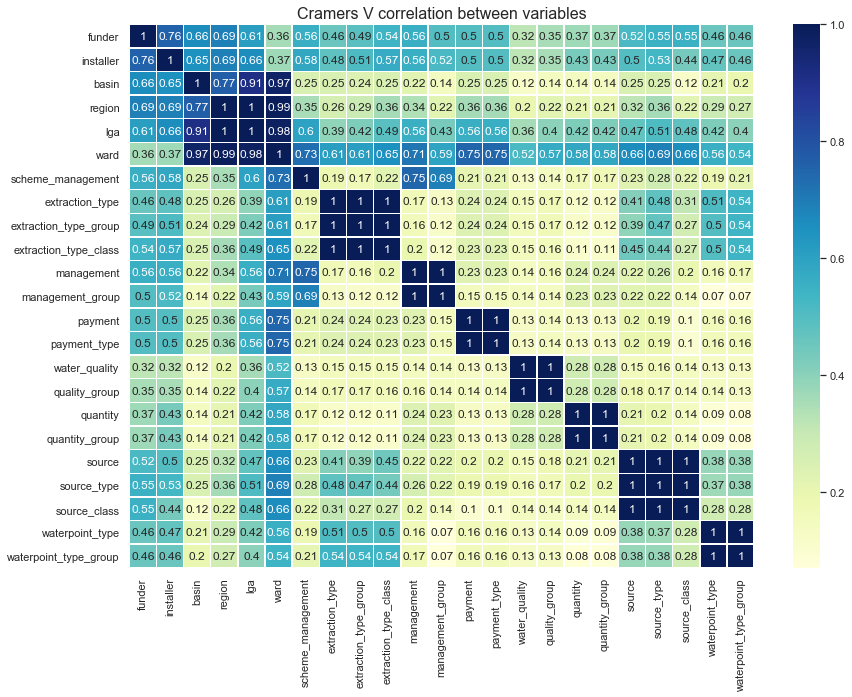

In [32]:
cat_correlation(df_str_enc.copy().drop(['status_group'],axis=1),cramers_stat)

The correlation matrix shows that some more columns can be dropped.

In [33]:
# if the columns are dropped in the correlation function by:
# setting a threshold
# and comparing Cramers V stat between each couple of columns and the threshold
# dropping the column that has higher number of levels/values
# a different set of columns to be dropped may result
# in the meantime, the following ones are dropped
cols_to_drop=['installer','lga','ward','extraction_type_group','extraction_type_class','management_group',
             'payment_type','quality_group','quantity_group','source_type','source_class','waterpoint_type_group']
#For consistency, the same columns can be dropped from df_str too (dataframe which isn't encoded)
df_str_enc.drop(cols_to_drop,axis=1,inplace=True)
df_str.drop(cols_to_drop,axis=1,inplace=True)
df_str_enc.columns

Index(['funder', 'basin', 'region', 'scheme_management', 'extraction_type',
       'management', 'payment', 'water_quality', 'quantity', 'source',
       'waterpoint_type', 'status_group'],
      dtype='object')

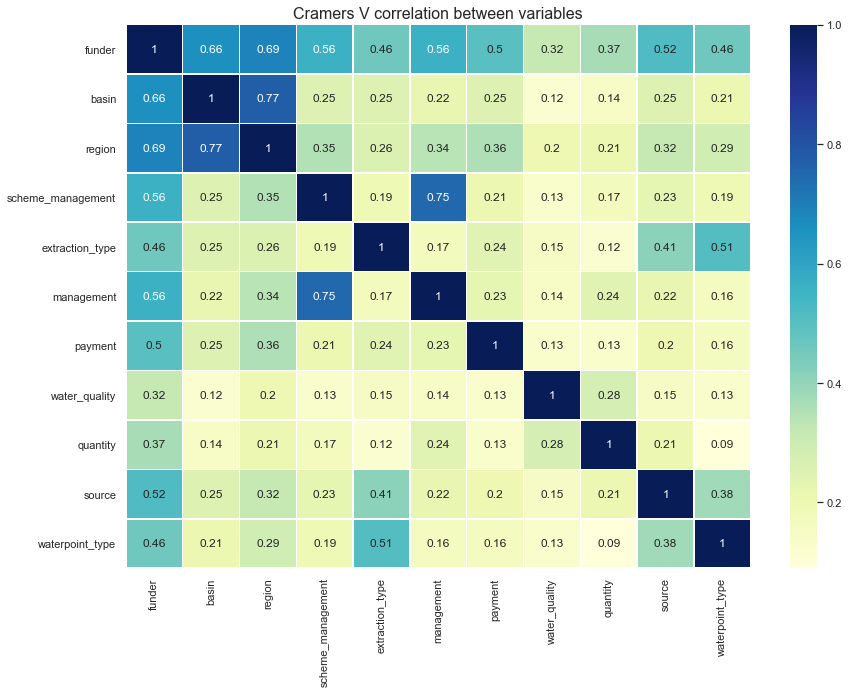

In [34]:
#re-check
cat_correlation(df_str_enc.copy().drop(['status_group'],axis=1),cramers_stat)

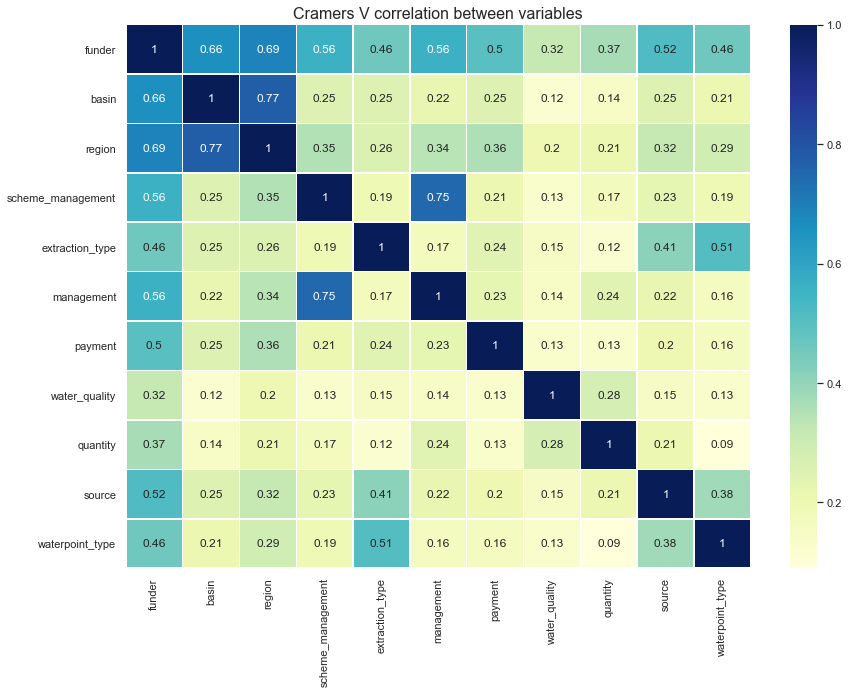

In [35]:
#check with the corrected Cramers V
cat_correlation(df_str_enc.copy().drop(['status_group'],axis=1),cramers_corrected_stat)

If a threshold of 0.75 is considered for the correlation, another couple of columns can be dropped. For now, they are kept, also because the region may be used later.

Numerical variables

In [36]:
new_types['int64']

['gps_height',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'recorded_year']

The "region_code" and "district_code" can be checked for correlation with the other categorical variables.

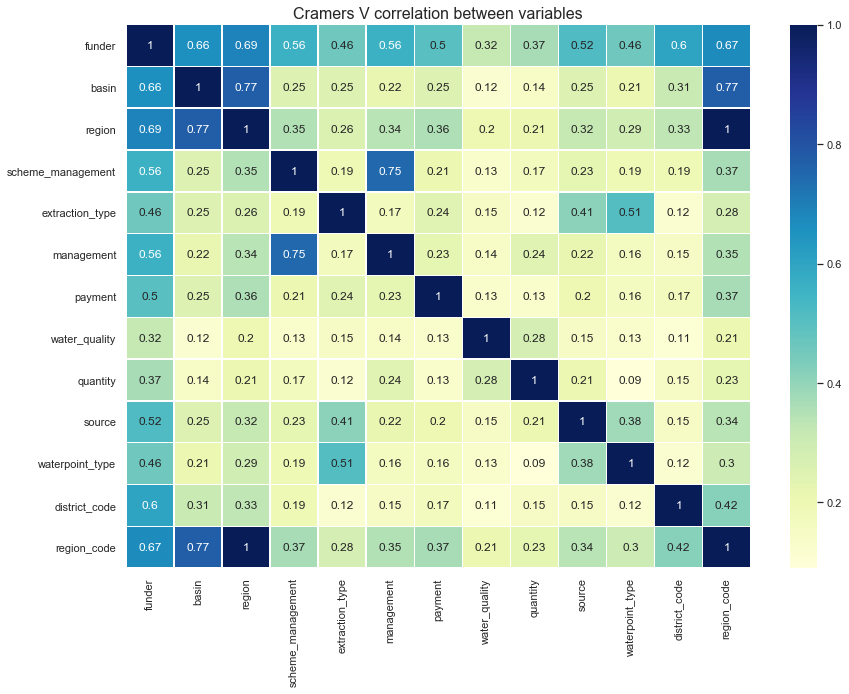

In [37]:
df_int=df[new_types['int64']].copy()
df_reg=pd.concat([df_str_enc.copy().drop(['status_group'],axis=1),df_int[['district_code','region_code']]],axis=1)
cat_correlation(df_reg,cramers_corrected_stat)

In [38]:
# another column can be dropped
df_int.drop('region_code',axis=1,inplace=True)

In [39]:
def q25(series):
    return series.quantile(25/100)

def q75(series):
    return series.quantile(75/100)    

In [40]:
def num_stats(col):
    
    '''main stats of numerical variable'''
    
    values=col.values
    avg=round(np.mean(values))
    md=np.median(values)
    std=round(np.std(values))
    per25=q25(col)
    per75=q75(col)
    return avg,md,std,per25,per75
    #print('Mean:',avg,'Median:',md,'','Std:',std,'','Q25:',per25,'','Q75:',per75)

def print_stats(col):
    
    avg,md,std,per25,per75=num_stats(col)
    print('Mean:',avg,'Median:',md,'','Std:',std,'','Q25:',per25,'','Q75:',per75)
    

In [41]:
stats_list=['mean','median','std','25% quantile','75% quantile']

In [42]:
df_float=df[new_types['float64']].copy()
df_num=pd.concat([df_int,df_float],axis=1)
df_num.columns

Index(['gps_height', 'num_private', 'district_code', 'population',
       'construction_year', 'recorded_year', 'amount_tsh', 'longitude',
       'latitude'],
      dtype='object')

In [43]:
for col in df_num.columns:
    print(col)
    print_stats(df_num[col])
    print('')

gps_height
Mean: 668.0 Median: 369.0  Std: 693.0  Q25: 0.0  Q75: 1319.25

num_private
Mean: 0.0 Median: 0.0  Std: 12.0  Q25: 0.0  Q75: 0.0

district_code
Mean: 6.0 Median: 3.0  Std: 10.0  Q25: 2.0  Q75: 5.0

population
Mean: 180.0 Median: 25.0  Std: 471.0  Q25: 0.0  Q75: 215.0

construction_year
Mean: 1301.0 Median: 1986.0  Std: 952.0  Q25: 0.0  Q75: 2004.0

recorded_year
Mean: 2012.0 Median: 2012.0  Std: 1.0  Q25: 2011.0  Q75: 2013.0

amount_tsh
Mean: 318.0 Median: 0.0  Std: 2998.0  Q25: 0.0  Q75: 20.0

longitude
Mean: 34.0 Median: 34.90874343  Std: 7.0  Q25: 33.09034738  Q75: 37.17838657

latitude
Mean: -6.0 Median: -5.021596649999999  Std: 3.0  Q25: -8.540621305  Q75: -3.3261556399999996



The above print out shows that:

"num_private" has 75% of values equal to 0, so it can be removed.

"gps_height", "population","construction_year" and "amount_tsh" have at least 25% of values equal to 0. These may be missing values or wrong entries. Dropping all of them might not be the best thing to do. The population and the amount of water are believed to be important features for the model. It's unlikely that the population is zero in many cases; the amount of water from the pump can be zero for various reasons, not just a missing value. For example, it can be an indication that the pump is broken, or maybe not enough to bring enough water to the whole population that uses it. The construction year is needed to calculate the age of the water pumps to be used for predictive maintenance.

For the time being, latitude and longitude are set aside, but they might have missing values as well.

In [44]:
df_num.drop('num_private',axis=1,inplace=True)
df_num.columns

Index(['gps_height', 'district_code', 'population', 'construction_year',
       'recorded_year', 'amount_tsh', 'longitude', 'latitude'],
      dtype='object')

To deal with some of the zero values, one option is to remove the rows that have any of the three features equal to zero. 

In [45]:
def perc_zero(col):
    
    total = (col==0).sum()
    return total, round(total/len(col)*100)

In [46]:
# For now, only the following variables are looked at. Longitude, latitude and gps_height will be dealt with later on.
numvar_list=['population','amount_tsh','construction_year']

In [47]:
def print_zero(df,col_list):
    
    for col in col_list:
        print('Total, percentage of zeros in {}: '.format(col),perc_zero(df[col]))

In [48]:
s=[df_num[col]==0 for col in numvar_list]
cond_zero=s[0] & s[1] & s[2]
print_zero(df_num,numvar_list)

Total, percentage of zeros in population:  (21381, 36.0)
Total, percentage of zeros in amount_tsh:  (41639, 70.0)
Total, percentage of zeros in construction_year:  (20709, 35.0)


Removing all the rows with an observation of value zero will reduce the dataframe entries to about 1/3 of the original size. This may result in a loss of information. Other options are considered as well, leading to different dataframes. The algorithms will be applied to all dataframes and the results compared.

In [49]:
cond_all_zeros=s[0] | s[1] | s[2]

In [50]:
# put the dataframe back together, then drop rows
df_enc=pd.concat([df_bool_enc,df_str_enc,df_num],axis=1)

In [51]:
df_reduced=df_enc.copy()
idx_todrop=df_reduced[cond_all_zeros].index
df_reduced.drop(idx_todrop,axis=0,inplace=True)
df_reduced.shape[0]

16557

In [52]:
# check that all rows with zeros have been removed (not considering latitude, longitude, gps_height)
print_zero(df_reduced,numvar_list)

Total, percentage of zeros in population:  (0, 0.0)
Total, percentage of zeros in amount_tsh:  (0, 0.0)
Total, percentage of zeros in construction_year:  (0, 0.0)


Another option is to replace the zeros with another value. Leaving the zeros unchanged might create issues when applying some transformation, for example a logarithmic function, and also when fitting the models. 
The first possibility is to add a small number. The second is to replace the zeros with a value related to some of the other features. This transformations are done on the population and amount attributes. For the construction year, a different strategy is considered,i.e. replacing the zeros with a few years earlier then the earliest reported. 

In [53]:
# move df_noenc definition here
# apply the same population and amount transformation to df_noenc (to use for visualization?)

In [54]:
def add_num(series,num=0.01):
    
    series += num

In [55]:
# For both the population and amount, 1 is added, although this can cause a big variation. A lower value can be used, 
# although adding a fraction of a person doesn't seem to make much sense
df_add=df_enc.copy()
add_num(df_add['population'],1)
add_num(df_add['amount_tsh'],1)
df_add.head(5)

,public_meeting,permit,funder,basin,region,scheme_management,extraction_type,management,payment,water_quality,...,waterpoint_type,status_group,gps_height,district_code,population,construction_year,recorded_year,amount_tsh,longitude,latitude
0,1.0,0.0,1368,1,3,7,3,7,2,6,...,1,0,1390,5,110,1999,2011,6001.0,34.938093,-9.856322
1,2.0,1.0,468,4,9,2,3,11,0,6,...,1,0,1399,2,281,2010,2013,1.0,34.698766,-2.147466
2,1.0,1.0,824,5,8,7,3,7,4,6,...,2,0,686,4,251,2009,2013,26.0,37.460664,-3.821329
3,1.0,1.0,1740,7,12,7,14,7,0,6,...,2,2,263,63,59,1986,2013,1.0,38.486161,-11.155298
4,1.0,1.0,19,4,4,12,3,1,0,6,...,1,0,0,1,1,0,2011,1.0,31.130847,-1.825359


In [56]:
print_zero(df_add,numvar_list)

Total, percentage of zeros in population:  (0, 0.0)
Total, percentage of zeros in amount_tsh:  (0, 0.0)
Total, percentage of zeros in construction_year:  (20709, 35.0)


In [57]:
# For the year, this transformation will be used for all the dataframes
print_stats(df_enc['construction_year'])
print(sorted(df_enc['construction_year'].unique().tolist())[:10])
print(sorted(df_enc['construction_year'].unique().tolist())[-10:])

Mean: 1301.0 Median: 1986.0  Std: 952.0  Q25: 0.0  Q75: 2004.0
[0, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968]
[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


In [58]:
# A function is written, to make the earliest year a parameter
def replace_year0(df,col,year='1959'):
    
    df[col]=[i if i!=0 else int(year) for i in df[col]]

In [59]:
replace_year0(df_enc,'construction_year')
print_stats(df_enc['construction_year'])
print(sorted(df_enc['construction_year'].unique().tolist())[:10])
print_zero(df_enc,['construction_year'])

Mean: 1984.0 Median: 1986.0  Std: 21.0  Q25: 1959.0  Q75: 2004.0
[1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968]
Total, percentage of zeros in construction_year:  (0, 0.0)


In [60]:
replace_year0(df_add,'construction_year')
print_zero(df_add,['construction_year'])

Total, percentage of zeros in construction_year:  (0, 0.0)


The other option to replace the zero in the population and amount of water is looked into here.

The idea is to see if the replacing values can be related to other attributes. 

For the population, some of the geographical features are used. 

In [61]:
# Since geographical features are considered, the original dataframe with no encoding is used, so that it's easier 
# to read
df_noenc=pd.concat([df_bool_enc,df_str,df_num],axis=1)

In [62]:
df_noenc.groupby(['basin','region'])['population'].agg([np.mean,np.median,np.std,np.max])

mean  median          std   amax
basin                   region                                                
Internal                Arusha          316.906035     200   532.107475   6000
                        Dodoma            0.000000       0     0.000000      0
                        Kilimanjaro       8.958580       1    64.933790    724
                        Manyara         325.140962     236   550.590263  15300
                        Shinyanga         0.000000       0     0.000000      0
                        Singida         248.207329     200   396.621276   5600
                        Tabora            0.000000       0     0.000000      0
Lake Nyasa              Iringa           56.974716      20   118.743525   1500
                        Mbeya             0.000000       0     0.000000      0
                        Ruvuma          193.919851      80   456.305574   7000
Lake Rukwa              Mbeya             0.000000       0     0.000000      0
                        Rukwa           394.663699     231   771.934843  10000
                        Singida        2500.000000    2500          NaN   2500
                        Tabora            0.000000       0     0.000000      0
Lake Tanganyika         Kagera            0.000000       0     0.000000      0
                        Kigoma          500.241832     360   590.075269   8500
                        Mwanza            0.000000       0     0.000000      0
                        Rukwa           329.176913     150   704.147339   6330
                        Shinyanga         0.000000       0     0.000000      0
                        Singida        1975.000000     700  3026.549190   9000
                        Tabora            0.000000       0     0.000000      0
Lake Victoria           Arusha          197.906250     190    93.506032    400
                        Kagera            0.000000       0     0.000000      0
                        Mara            538.794312     300   831.300180  10000
                        Mwanza           67.469197       0   249.868625   5000
                        Shinyanga        30.961216       0   126.159795   1500
Pangani                 Arusha          227.644599     150   372.923120   9500
                        Kilimanjaro     109.633254      40   299.175925   8000
                        Manyara         232.625000     200   452.023023   7530
                        Tanga           228.528566      70   769.688130  30500
Rufiji                  Dodoma            0.000000       0     0.000000      0
                        Iringa          110.213631      50   211.792227   3072
                        Lindi           305.944444     277   180.870142   1500
                        Mbeya             0.000000       0     0.000000      0
                        Morogoro        287.999472     240   283.425871   3000
                        Pwani           282.054847       1   752.515381   8000
                        Ruvuma          322.661538     250   264.296489   1800
                        Singida         776.891304     425   943.523772   4800
                        Tabora            0.000000       0     0.000000      0
Ruvuma / Southern Coast Lindi           368.018544     300   409.715579   5050
                        Mtwara          267.441618     123   443.022905   5016
                        Ruvuma          178.609793       1   466.663271   8000
Wami / Ruvu             Dar es Salaam   240.843478     150   534.198421   9865
                        Dodoma            0.000000       0     0.000000      0
                        Manyara         493.561798     230  1105.101373   8000
                        Morogoro        243.685282     150   375.865176   5000
                        Pwani           378.047002      60  1047.943658  11463
                        Tanga           635.719298     300  1077.295438   6854

The regions that have zero population are filled in with the mean of the population of all the regions in the same basin.

In [63]:
basins_popmean=df_noenc.groupby(['basin'])['population'].mean()
basins=basins_popmean.index.tolist()
basins_popmean

basin
Internal                   167.359409
Lake Nyasa                  58.645034
Lake Rukwa                 163.612469
Lake Tanganyika            262.256685
Lake Victoria              130.765027
Pangani                    172.472036
Rufiji                     170.301906
Ruvuma / Southern Coast    274.193635
Wami / Ruvu                254.710205
Name: population, dtype: float64

In [64]:
df_bas_pop=df_noenc[['basin','region','population']].copy()
for i,bas in enumerate(basins):
    cond_bas=(df_bas_pop['basin']==bas) & (df_bas_pop['population']==0)
    df_bas_pop.loc[cond_bas,'population']=int(basins_popmean[i])
df_bas_pop.head(7)    

,basin,region,population
0,Lake Nyasa,Iringa,109
1,Lake Victoria,Mara,280
2,Pangani,Manyara,250
3,Ruvuma / Southern Coast,Mtwara,58
4,Lake Victoria,Kagera,130
5,Pangani,Tanga,1
6,Internal,Shinyanga,167


In [65]:
# check that it worked everywhere
print_zero(df_bas_pop,['population'])

Total, percentage of zeros in population:  (0, 0.0)


For the amount of water, the pump status is considered.

In [66]:
df_bas_am=df_noenc[['basin','amount_tsh','status_group']].copy()
status_basin_gr=df_bas_am.groupby(['status_group','basin'])
#status_basin_gr.groups.keys()

In [67]:
df_status_basin=status_basin_gr['amount_tsh'].mean()
df_status_basin

status_group             basin                  
functional               Internal                    335.976127
                         Lake Nyasa                  720.397112
                         Lake Rukwa                  584.225000
                         Lake Tanganyika             232.547473
                         Lake Victoria                35.967843
                         Pangani                     389.332325
                         Rufiji                      958.309984
                         Ruvuma / Southern Coast     405.681437
                         Wami / Ruvu                 599.751913
functional needs repair  Internal                    139.263914
                         Lake Nyasa                  227.600000
                         Lake Rukwa                 1006.500000
                         Lake Tanganyika             393.524259
                         Lake Victoria                13.245703
                         Pangani                     30

In [68]:
meanby_status_basin=df_status_basin.unstack(level='basin')
meanby_status_basin

basin,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
status_group,,,,,,,,,
functional,335.976127,720.397112,584.225000,232.547473,35.967843,389.332325,958.309984,405.681437,599.751913
functional needs repair,139.263914,227.600000,1006.500000,393.524259,13.245703,300.918239,329.176201,352.193252,146.561338
non functional,41.902840,172.296492,215.342061,131.504065,29.382063,136.647169,319.949413,93.654385,108.158017


Te zero amount are replaced by the mean amount for the basin the pump is in and depending on the status.

In [69]:
amount_zero=df_bas_am['amount_tsh']==0
amount_zero.head()

0    False
1     True
2    False
3     True
4     True
Name: amount_tsh, dtype: bool

In [70]:
df_bas_am.head()

,basin,amount_tsh,status_group
0,Lake Nyasa,6000.0,functional
1,Lake Victoria,0.0,functional
2,Pangani,25.0,functional
3,Ruvuma / Southern Coast,0.0,non functional
4,Lake Victoria,0.0,functional


In [71]:
for ind in df_bas_am.index:
    
    if df_bas_am.loc[ind,'amount_tsh']!=0: continue
    sta=df_bas_am.loc[ind,'status_group']
    bas=df_bas_am.loc[ind,'basin']
    df_bas_am.loc[ind,'amount_tsh']=meanby_status_basin.loc[sta,bas]   

df_bas_am.head()    

,basin,amount_tsh,status_group
0,Lake Nyasa,6000.000000,functional
1,Lake Victoria,35.967843,functional
2,Pangani,25.000000,functional
3,Ruvuma / Southern Coast,93.654385,non functional
4,Lake Victoria,35.967843,functional


In [72]:
# check that it worked
print_zero(df_bas_am,['amount_tsh'])

Total, percentage of zeros in amount_tsh:  (0, 0.0)


In [73]:
# Is there a faster, more efficient way to apply the above transformation?

Finally, the dataframe is put back together with the new population and amount columns.

In [74]:
# The encoded dataframe can be copied, since only the numerical features are modified
df_mean=df_enc.copy()
df_mean['population']=df_bas_pop['population']
df_mean['amount_tsh']=df_bas_am['amount_tsh']
print_zero(df_mean,['population'])
print_zero(df_mean,['amount_tsh'])

Total, percentage of zeros in population:  (0, 0.0)
Total, percentage of zeros in amount_tsh:  (0, 0.0)


In [75]:
# re-create dataframes with object variables and updated population and amount for data visualization purposes.
# or use df_noenc

EXPLORATORY DATA ANALYSES

In [76]:
def plot_1box(df,name,ax):
    
    '''box plot of a numeric feature'''
    
    labels=[]
    stats=num_stats(df[name])
    for i,s in enumerate(stats): labels.append(stats_list[i]+': '+str(stats[i]))
    fig,ax=plt.subplots(1,1)
    _ = sns.boxplot(name,data=df,orient='v',ax=ax)
    #_ = plt.title('{}'.format(name))
    _ = plt.legend(labels,loc='best')

In [77]:
def features_box(df):
    
    '''box plot of numeric features'''
    
    #fig,axs=plt.subplots(1,2,figsize=(20,8))
    fig,axs=plt.subplots(1,2)
    #plt.subplots_adjust(wspace=0.35,hspace=0.3)
    for i,col in enumerate(df.columns):
        plot_1box(df,col,ax=axs.flatten()[i])
    plt.close(1)

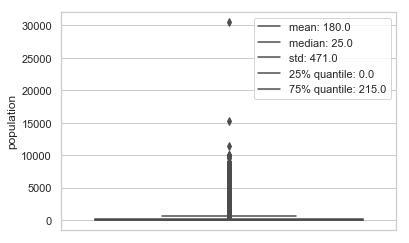

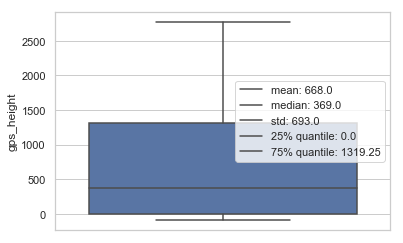

In [78]:
features_box(df_enc[['population','gps_height']])

In [79]:
# why doesn't Seaborn keep the number of rows and columns I chose?